# Crypto EDA

## Packages

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import r2_score
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sklearn.metrics as skm

import xgboost as xgb

## Crypto data range

### Start Date & Days

In [3]:
directory = "crypto_csv/"

cryptos = []

for name in os.listdir(directory):
    df = pd.read_csv(directory+name,index_col=False)
    df["date"] = pd.to_datetime(df.date)
    
    if "exchangeVolume(USD)" in df.columns:
        mask = df["exchangeVolume(USD)"]>0
        cryptos.append((name,str(min(df.date).date()),len(df.date),len(df[mask].date)))
    else:
        cryptos.append((name,str(min(df.date).date()),len(df.date)))
    
cryptos.sort(key=lambda x: x[2])

cryptos

[('btg.csv', '2017-11-16', 137, 137),
 ('icx.csv', '2017-10-30', 154, 154),
 ('rhoc.csv', '2017-10-09', 175, 175),
 ('ada.csv', '2017-10-04', 180, 180),
 ('salt.csv', '2017-10-02', 182, 182),
 ('knc.csv', '2017-09-27', 187, 187),
 ('trx.csv', '2017-09-16', 198, 198),
 ('wtc.csv', '2017-08-30', 215, 215),
 ('ven.csv', '2017-08-25', 220, 217),
 ('zrx.csv', '2017-08-19', 226, 226),
 ('btm.csv', '2017-08-11', 234, 234),
 ('bch.csv', '2017-08-03', 242, 242),
 ('bnb.csv', '2017-07-28', 248, 248),
 ('ethos.csv', '2017-07-21', 255, 255),
 ('cvc.csv', '2017-07-20', 256, 256),
 ('omg.csv', '2017-07-17', 259, 259),
 ('ppt.csv', '2017-07-14', 262, 262),
 ('mtl.csv', '2017-07-12', 264, 264),
 ('gas.csv', '2017-07-09', 267, 267),
 ('eos.csv', '2017-07-04', 272, 272),
 ('snt.csv', '2017-07-01', 275, 275),
 ('pay.csv', '2017-06-30', 276, 276),
 ('fun.csv', '2017-06-30', 276, 276),
 ('veri.csv', '2017-06-11', 295, 295),
 ('bat.csv', '2017-06-04', 302, 302),
 ('ae.csv', '2017-06-04', 302, 302),
 ('ant.c

In [4]:
df_temp = pd.read_csv("crypto_csv/trend_blockchain.csv", index_col = False)
df_temp.head(10)

,date,val
0,2014-01-05,0.390863
1,2014-01-06,0.497462
2,2014-01-07,0.446701
3,2014-01-08,0.411168
4,2014-01-09,0.456853
5,2014-01-10,0.507614
6,2014-01-11,0.289340
7,2014-01-12,0.424191
8,2014-01-13,0.470187
9,2014-01-14,0.511073


## BTC EDA

### Data Load

In [5]:
def load_econ_data(index, dir_path="crypto_csv/" ):
    df = pd.read_csv(dir_path+index+".csv",index_col=False)
    df.columns = [x.replace("(USD)","").lower() for x in df.columns]
    
    df["date"]=pd.to_datetime(df.date,yearfirst=True)
    df.set_index("date",drop=True,inplace=True)

    df.columns = [index+"_"+x for x in df.columns]

    return df

def load_crypto_data(symbol, dir_path = "crypto_csv/",
                     features = ['price_close', 'fees', 'txcount', 'tx_unit', 'ex_unit']):

    df = pd.read_csv(dir_path+symbol+".csv",index_col=False)
    df.columns = [x.replace("(USD)","").lower() for x in df.columns]
        
    df.drop(columns=["activeaddresses","marketcap","generatedcoins"], inplace=True)
    
    # Rename prices
    df.rename({"price":"price_open", "txvolume":"tx_dollar", "exchangevolume":"ex_dollar"},axis="columns",inplace=True)
    df["price_close"] = df.price_open.shift(-1)

    # Change volume from dollar to unit volume
    df["tx_unit"] = df.tx_dollar / ((df.price_open + df.price_close)/2)
    df["ex_unit"] = df.ex_dollar / ((df.price_open + df.price_close)/2)
    
    # Set date index
    df["date"]=pd.to_datetime(df.date,yearfirst=True)
    df.set_index("date",drop=True,inplace=True,)
    
    df = df[features]
    
    df.columns = [symbol+"_"+x for x in df.columns]
    
    return df
    

In [6]:
df_btc = load_crypto_data("btc")
#df_ltc = load_crypto_data("ltc")

indices = ['sp500','gold','liborusd','trend_bitcoin','trend_blockchain']
econ_dfs = []
for i in indices:
    econ_dfs.append(load_econ_data(i))

df_data = pd.concat([df_btc]+econ_dfs, axis=1)

df_data.dropna(inplace=True)

df_data.head(10)


,btc_price_close,btc_fees,btc_txcount,btc_tx_unit,btc_ex_unit,sp500_value,gold_value,liborusd_value,trend_bitcoin_val,trend_blockchain_val
date,,,,,,,,,,
2014-01-05,936.05,13.618094,57249.0,817104.957855,81242.059512,1834.6250,1234.8750,0.16310,0.906977,0.390863
2014-01-06,946.49,29.820238,67748.0,884739.889081,90904.522613,1836.2525,1236.1875,0.16230,1.162791,0.497462
2014-01-07,795.99,15.217180,61942.0,831540.009076,93328.703916,1837.8800,1237.5000,0.16150,1.023256,0.446701
2014-01-08,841.47,14.208043,61835.0,892859.024357,90598.365762,1837.4900,1226.5000,0.16100,1.034884,0.411168
2014-01-09,846.69,13.064602,59205.0,477200.269434,71081.651028,1838.1300,1226.0000,0.16030,0.965116,0.456853
2014-01-10,867.32,12.736282,55439.0,543956.938100,37195.582289,1842.3700,1232.2500,0.16040,1.023256,0.507614
2014-01-11,919.60,12.380139,56268.0,353583.451030,50090.882636,1841.4975,1236.3750,0.16005,0.883721,0.289340
2014-01-12,860.19,11.740429,49454.0,348201.337681,44526.039589,1840.6250,1240.5000,0.15970,0.822186,0.424191
2014-01-13,843.17,12.285570,54042.0,471065.667093,53518.809882,1839.7525,1244.6250,0.15935,0.783034,0.470187


In [7]:
df_data.tail()

,btc_price_close,btc_fees,btc_txcount,btc_tx_unit,btc_ex_unit,sp500_value,gold_value,liborusd_value,trend_bitcoin_val,trend_blockchain_val
date,,,,,,,,,,
2018-03-19,8619.67,30.780649,191373.0,633308.890095,793349.835149,2725.7075,1314.575,1.845883,2.896552,7.557627
2018-03-20,8937.48,31.379079,195041.0,574464.053402,724695.067252,2716.9400,1312.750,1.853820,2.719212,7.806780
2018-03-21,8939.44,31.025274,194694.0,673501.340658,676081.785900,2711.9300,1316.350,1.861250,2.541872,7.640678
2018-03-22,8736.25,27.724789,185044.0,583454.053966,625762.275758,2643.6900,1328.850,1.871500,2.512315,8.305085
2018-03-23,8901.95,26.257673,179685.0,585693.947225,675139.186538,2588.2600,1342.350,1.875000,2.334975,7.474576


### Plots (Values)

In [8]:
def plot_series(series, n=30, figsize=(15,4)):
    plt.figure(figsize=figsize)
    plt.plot(series)
    plt.plot(series.rolling(n).mean(),"r",label="rolling mean")
    plt.plot(series.rolling(n).std(),"orange", label="rolling std")
    plt.legend()
        
def plot_log10_diff(series, n=30, figsize=(15,4)):
    plot_series(series, n, figsize)
#    plot_series(series-series.shift(1), n, figsize)
#    plot_series(np.log10(series), n, figsize)
    plot_series(np.log10(series)-np.log10(df.price.shift(1)))

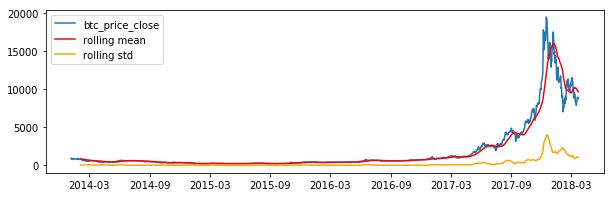

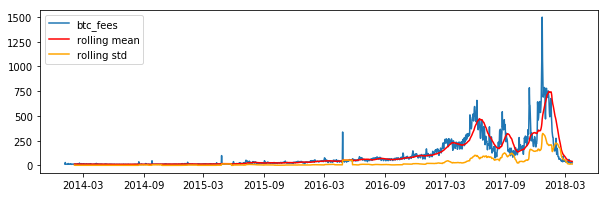

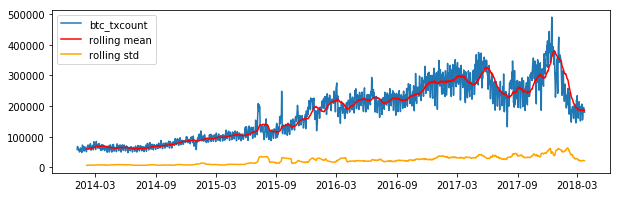

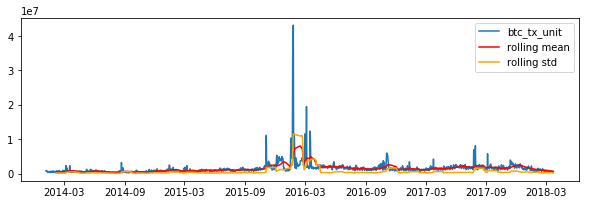

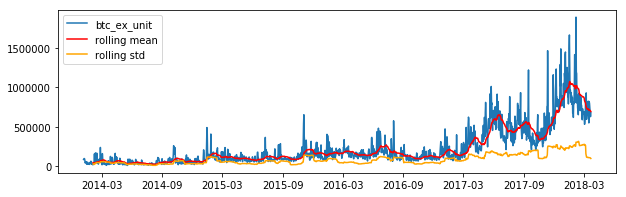

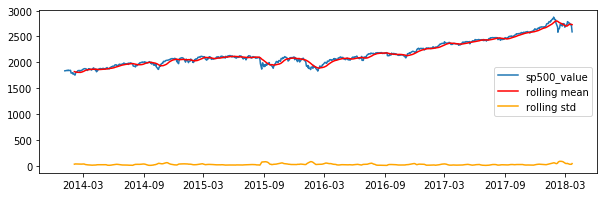

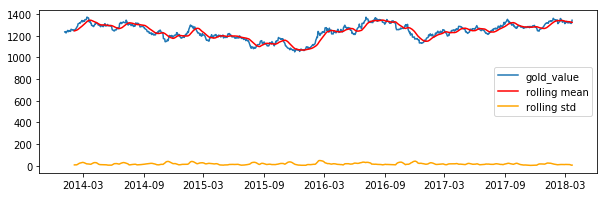

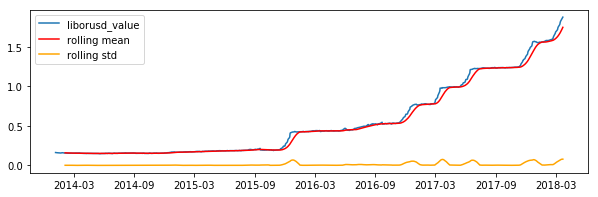

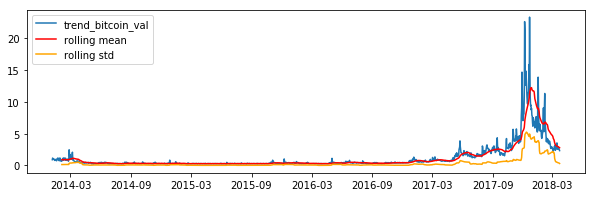

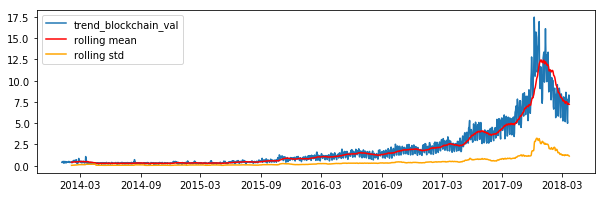

In [16]:
for f in df_data.columns:
    plot_series(df_data[f], figsize=(10,3))

### Plots (Returns)

In [9]:
def convert_daily_return(series):
    lag = series.shift(1)
    return (series - lag)/lag

def invert_daily_return(series,returns):
    lag = series.shift(1)
    return  (lag * returns) + lag

In [10]:
df_returns = df_data.apply(convert_daily_return).dropna()[1:]

df_returns.head()

,btc_price_close,btc_fees,btc_txcount,btc_tx_unit,btc_ex_unit,sp500_value,gold_value,liborusd_value,trend_bitcoin_val,trend_blockchain_val
date,,,,,,,,,,
2014-01-07,-0.159009,-0.489703,-0.085700,-0.060131,0.026667,0.000886,0.001062,-0.004929,-0.120000,-0.102041
2014-01-08,0.057136,-0.066316,-0.001727,0.073742,-0.029255,-0.000212,-0.008889,-0.003096,0.011364,-0.079545
2014-01-09,0.006203,-0.080478,-0.042533,-0.465537,-0.215420,0.000348,-0.000408,-0.004348,-0.067416,0.111111
2014-01-10,0.024365,-0.025131,-0.063609,0.139892,-0.476720,0.002307,0.005098,0.000624,0.060241,0.111111
2014-01-11,0.060278,-0.027963,0.014953,-0.349979,0.346689,-0.000474,0.003348,-0.002182,-0.136364,-0.430000


(array([  5.,  10.,  39., 170., 964., 282.,  50.,  11.,   4.,   2.]),
 array([-0.20987985, -0.16384572, -0.11781159, -0.07177745, -0.02574332,
         0.02029081,  0.06632494,  0.11235908,  0.15839321,  0.20442734,
         0.25046148]),
 <a list of 10 Patch objects>)

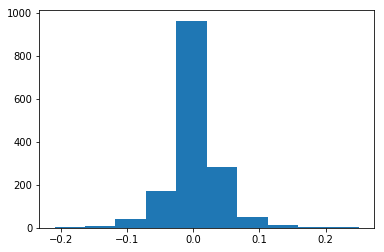

In [19]:
plt.hist(df_returns.btc_price_close)

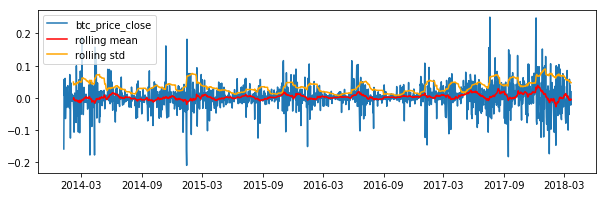

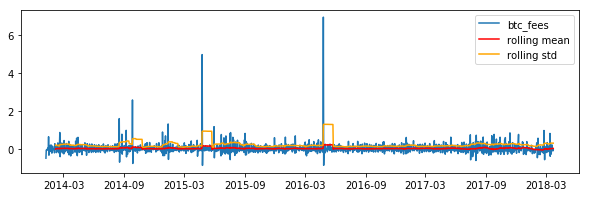

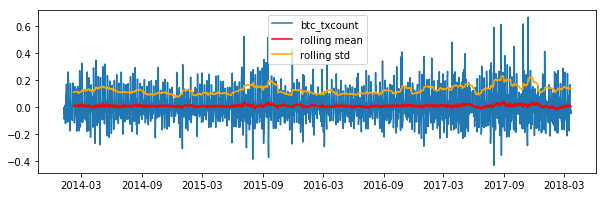

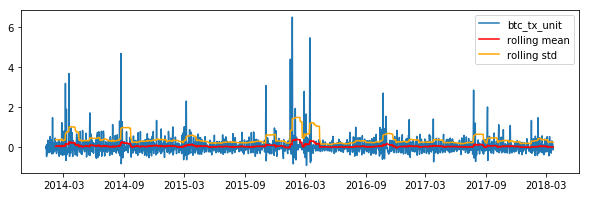

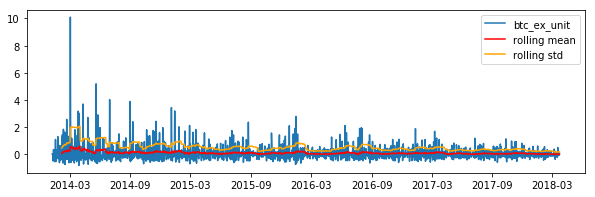

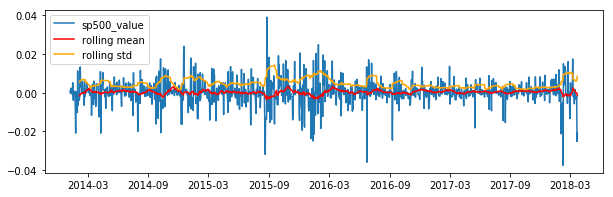

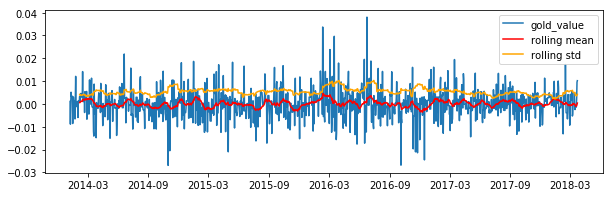

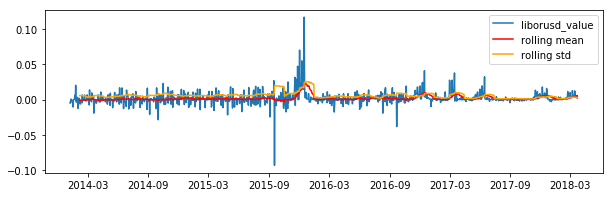

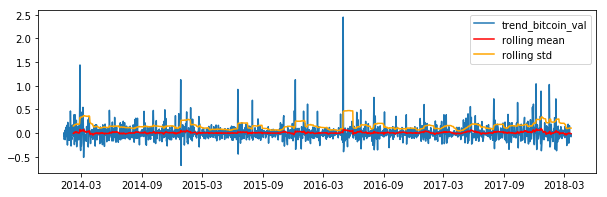

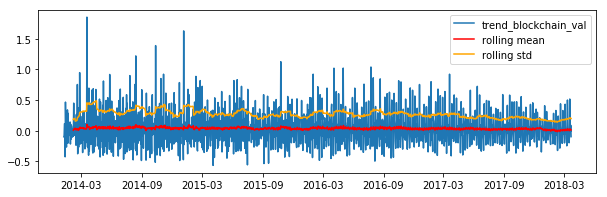

In [20]:
for f in df_returns.columns:
    plot_series(df_returns[f], figsize=(10,3))

### Correlations

In [22]:
df_returns_next = df_returns.shift(-1)
df_returns_next.columns = ["next_"+name for name in df_returns_next.columns]
df_temp = pd.concat([df_returns,df_returns_next],axis=1)

df_temp.dropna().head()

,btc_price_close,btc_fees,btc_txcount,btc_tx_unit,btc_ex_unit,ltc_price_close,ltc_fees,ltc_txcount,ltc_tx_unit,ltc_ex_unit,...,next_btc_tx_unit,next_btc_ex_unit,next_ltc_price_close,next_ltc_fees,next_ltc_txcount,next_ltc_tx_unit,next_ltc_ex_unit,next_sp500_value,next_gold_value,next_liborusd_value
date,,,,,,,,,,,,,,,,,,,,,
2013-12-28,-0.013456,-0.076066,-0.120415,0.322721,-0.289692,-0.027167,-0.251682,-0.162346,-0.798585,-0.628928,...,0.126390,-0.416483,0.058954,-0.188635,-0.027300,-0.048610,0.018988,0.000944,-0.001605,-0.001927
2013-12-29,0.018268,0.171917,0.052675,0.126390,-0.416483,0.058954,-0.188635,-0.027300,-0.048610,0.018988,...,-0.019331,0.065824,0.025952,0.314570,0.245635,0.507767,0.048683,0.000943,-0.001607,-0.001931
2013-12-30,0.025588,-0.021692,0.128947,-0.019331,0.065824,0.025952,0.314570,0.245635,0.507767,0.048683,...,-0.322771,0.000085,-0.006528,-0.178384,-0.177159,1.053269,-0.406994,0.000942,-0.001610,-0.001934
2013-12-31,-0.007037,-0.146693,-0.090370,-0.322771,0.000085,-0.006528,-0.178384,-0.177159,1.053269,-0.406994,...,-0.017056,0.066949,0.014374,-0.207201,-0.063023,-0.712731,0.082494,-0.004431,0.007595,0.001789
2014-01-01,0.024465,-0.199175,-0.204533,-0.017056,0.066949,0.014374,-0.207201,-0.063023,-0.712731,0.082494,...,0.165866,0.659465,0.039271,0.248466,0.227105,0.295461,1.990101,-0.004451,0.007537,0.001786


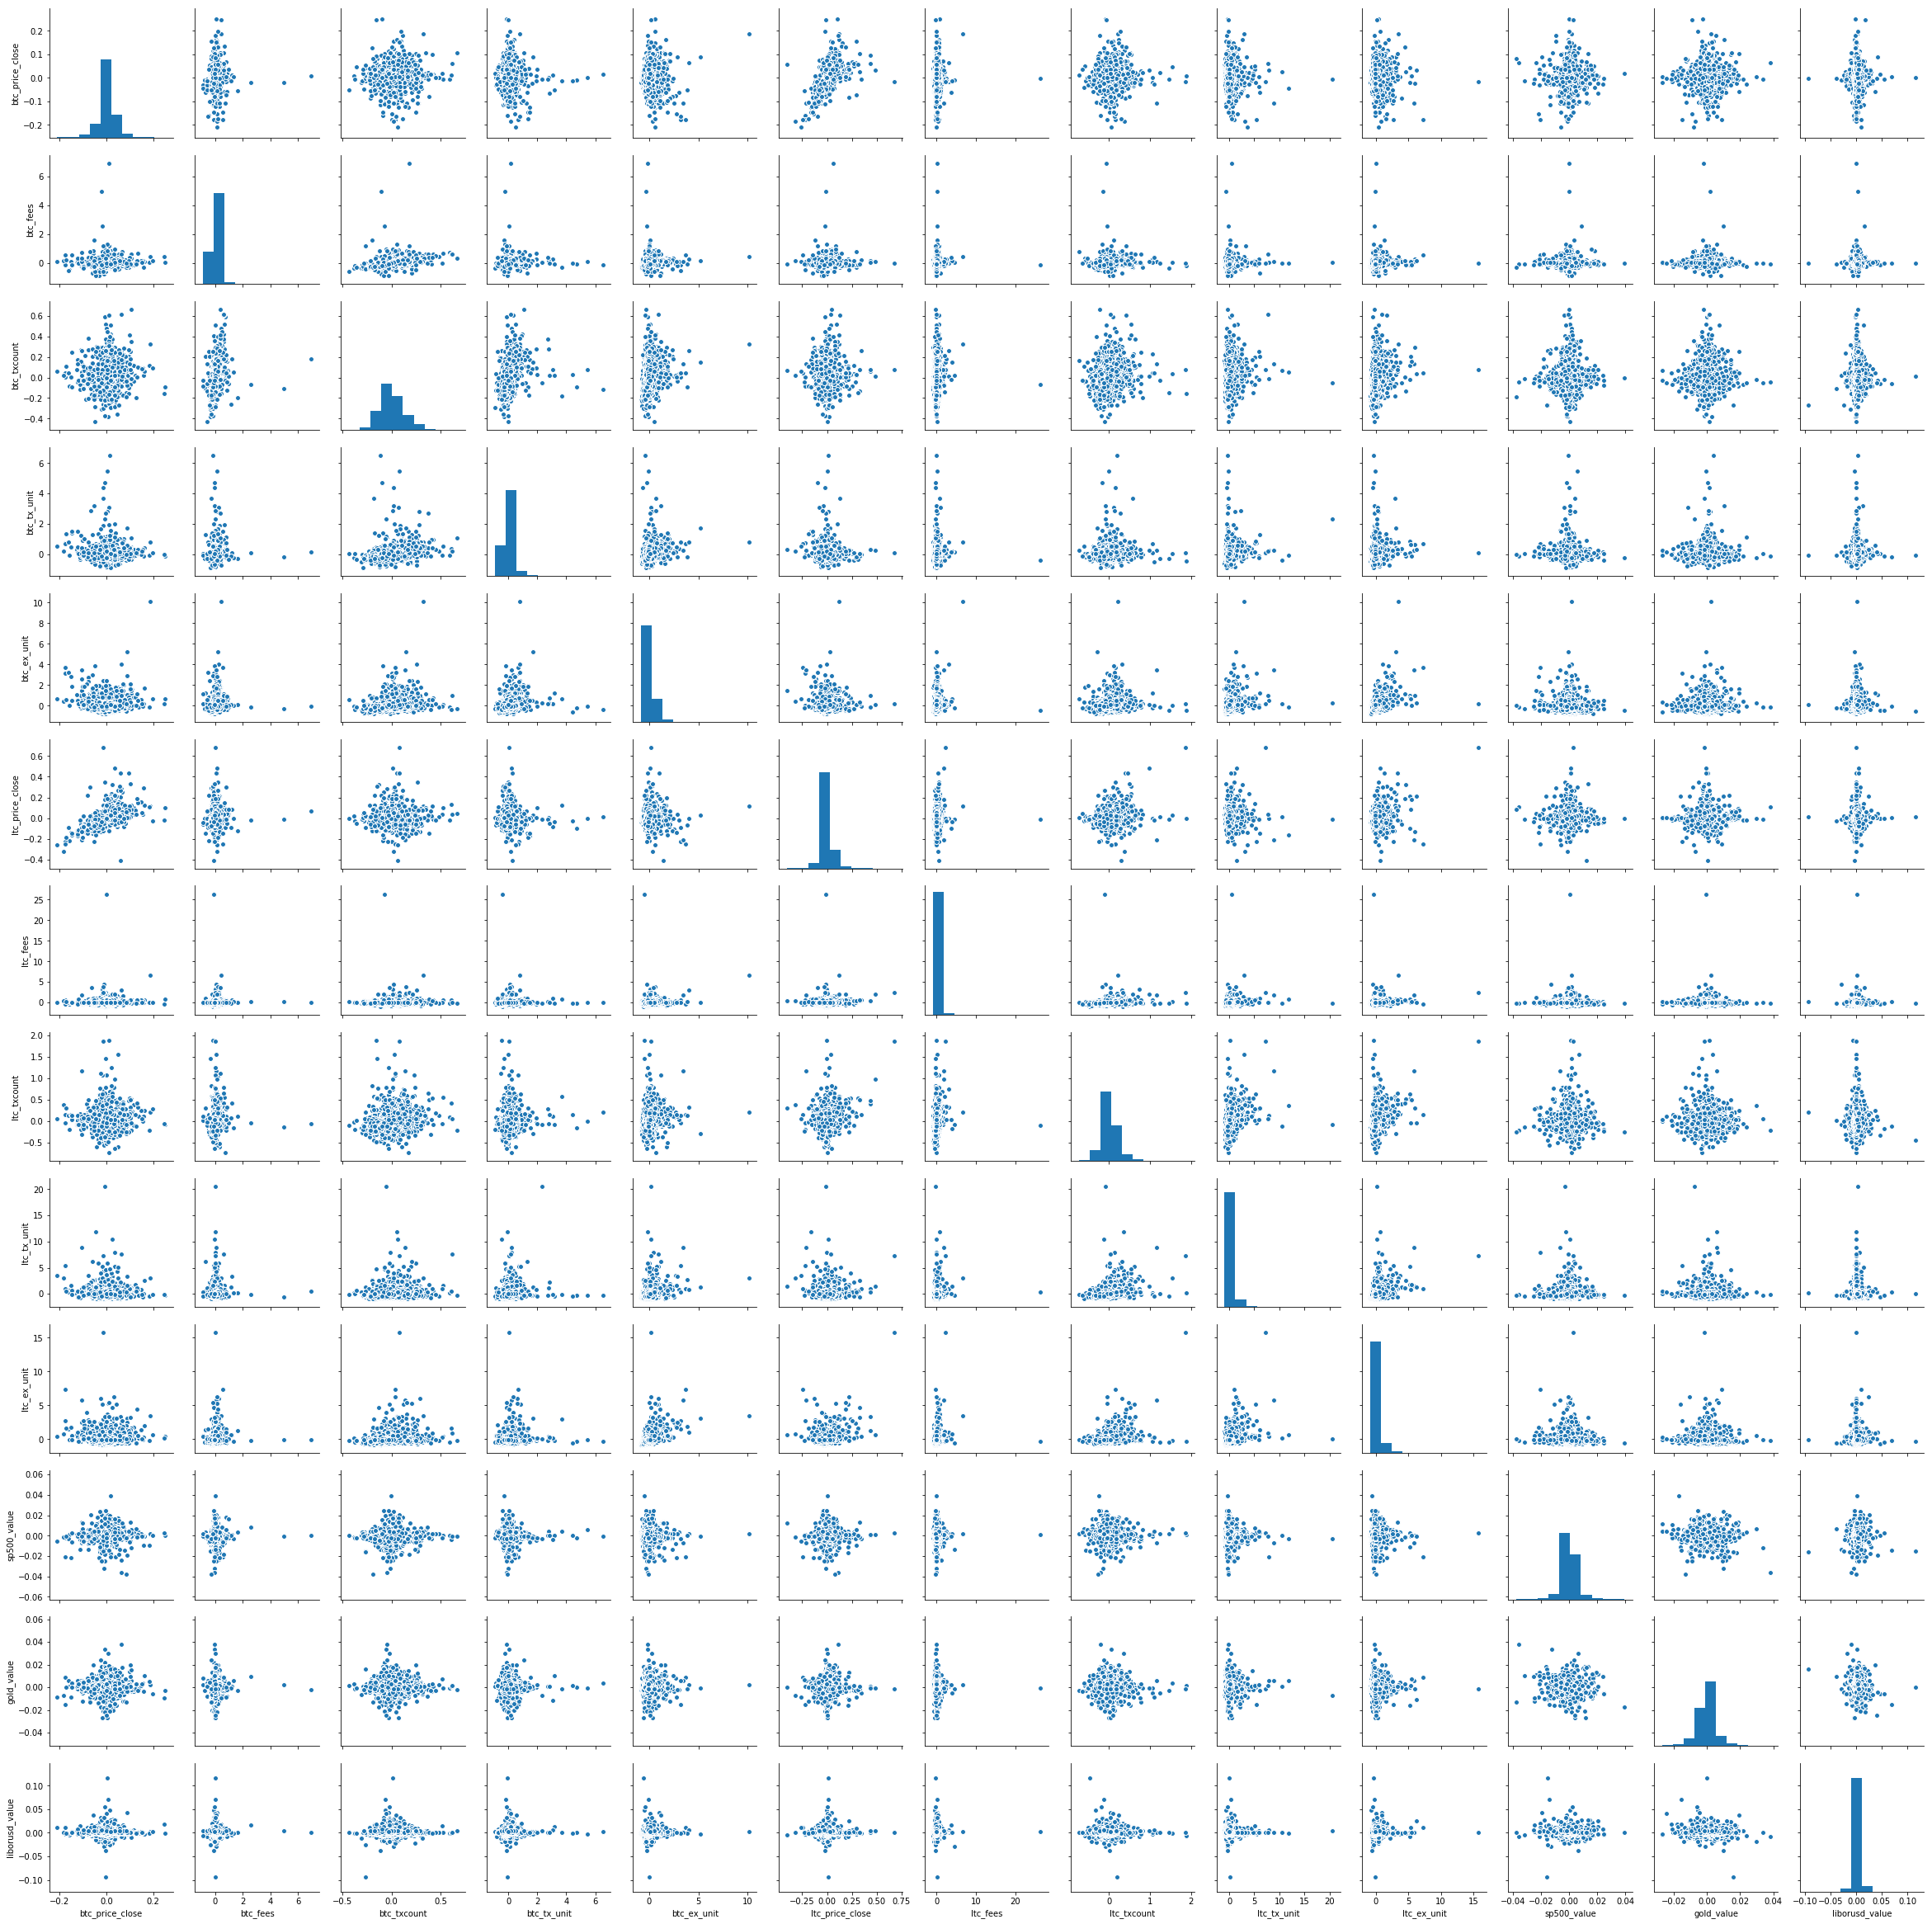

In [23]:
sns.pairplot(df_returns.dropna())

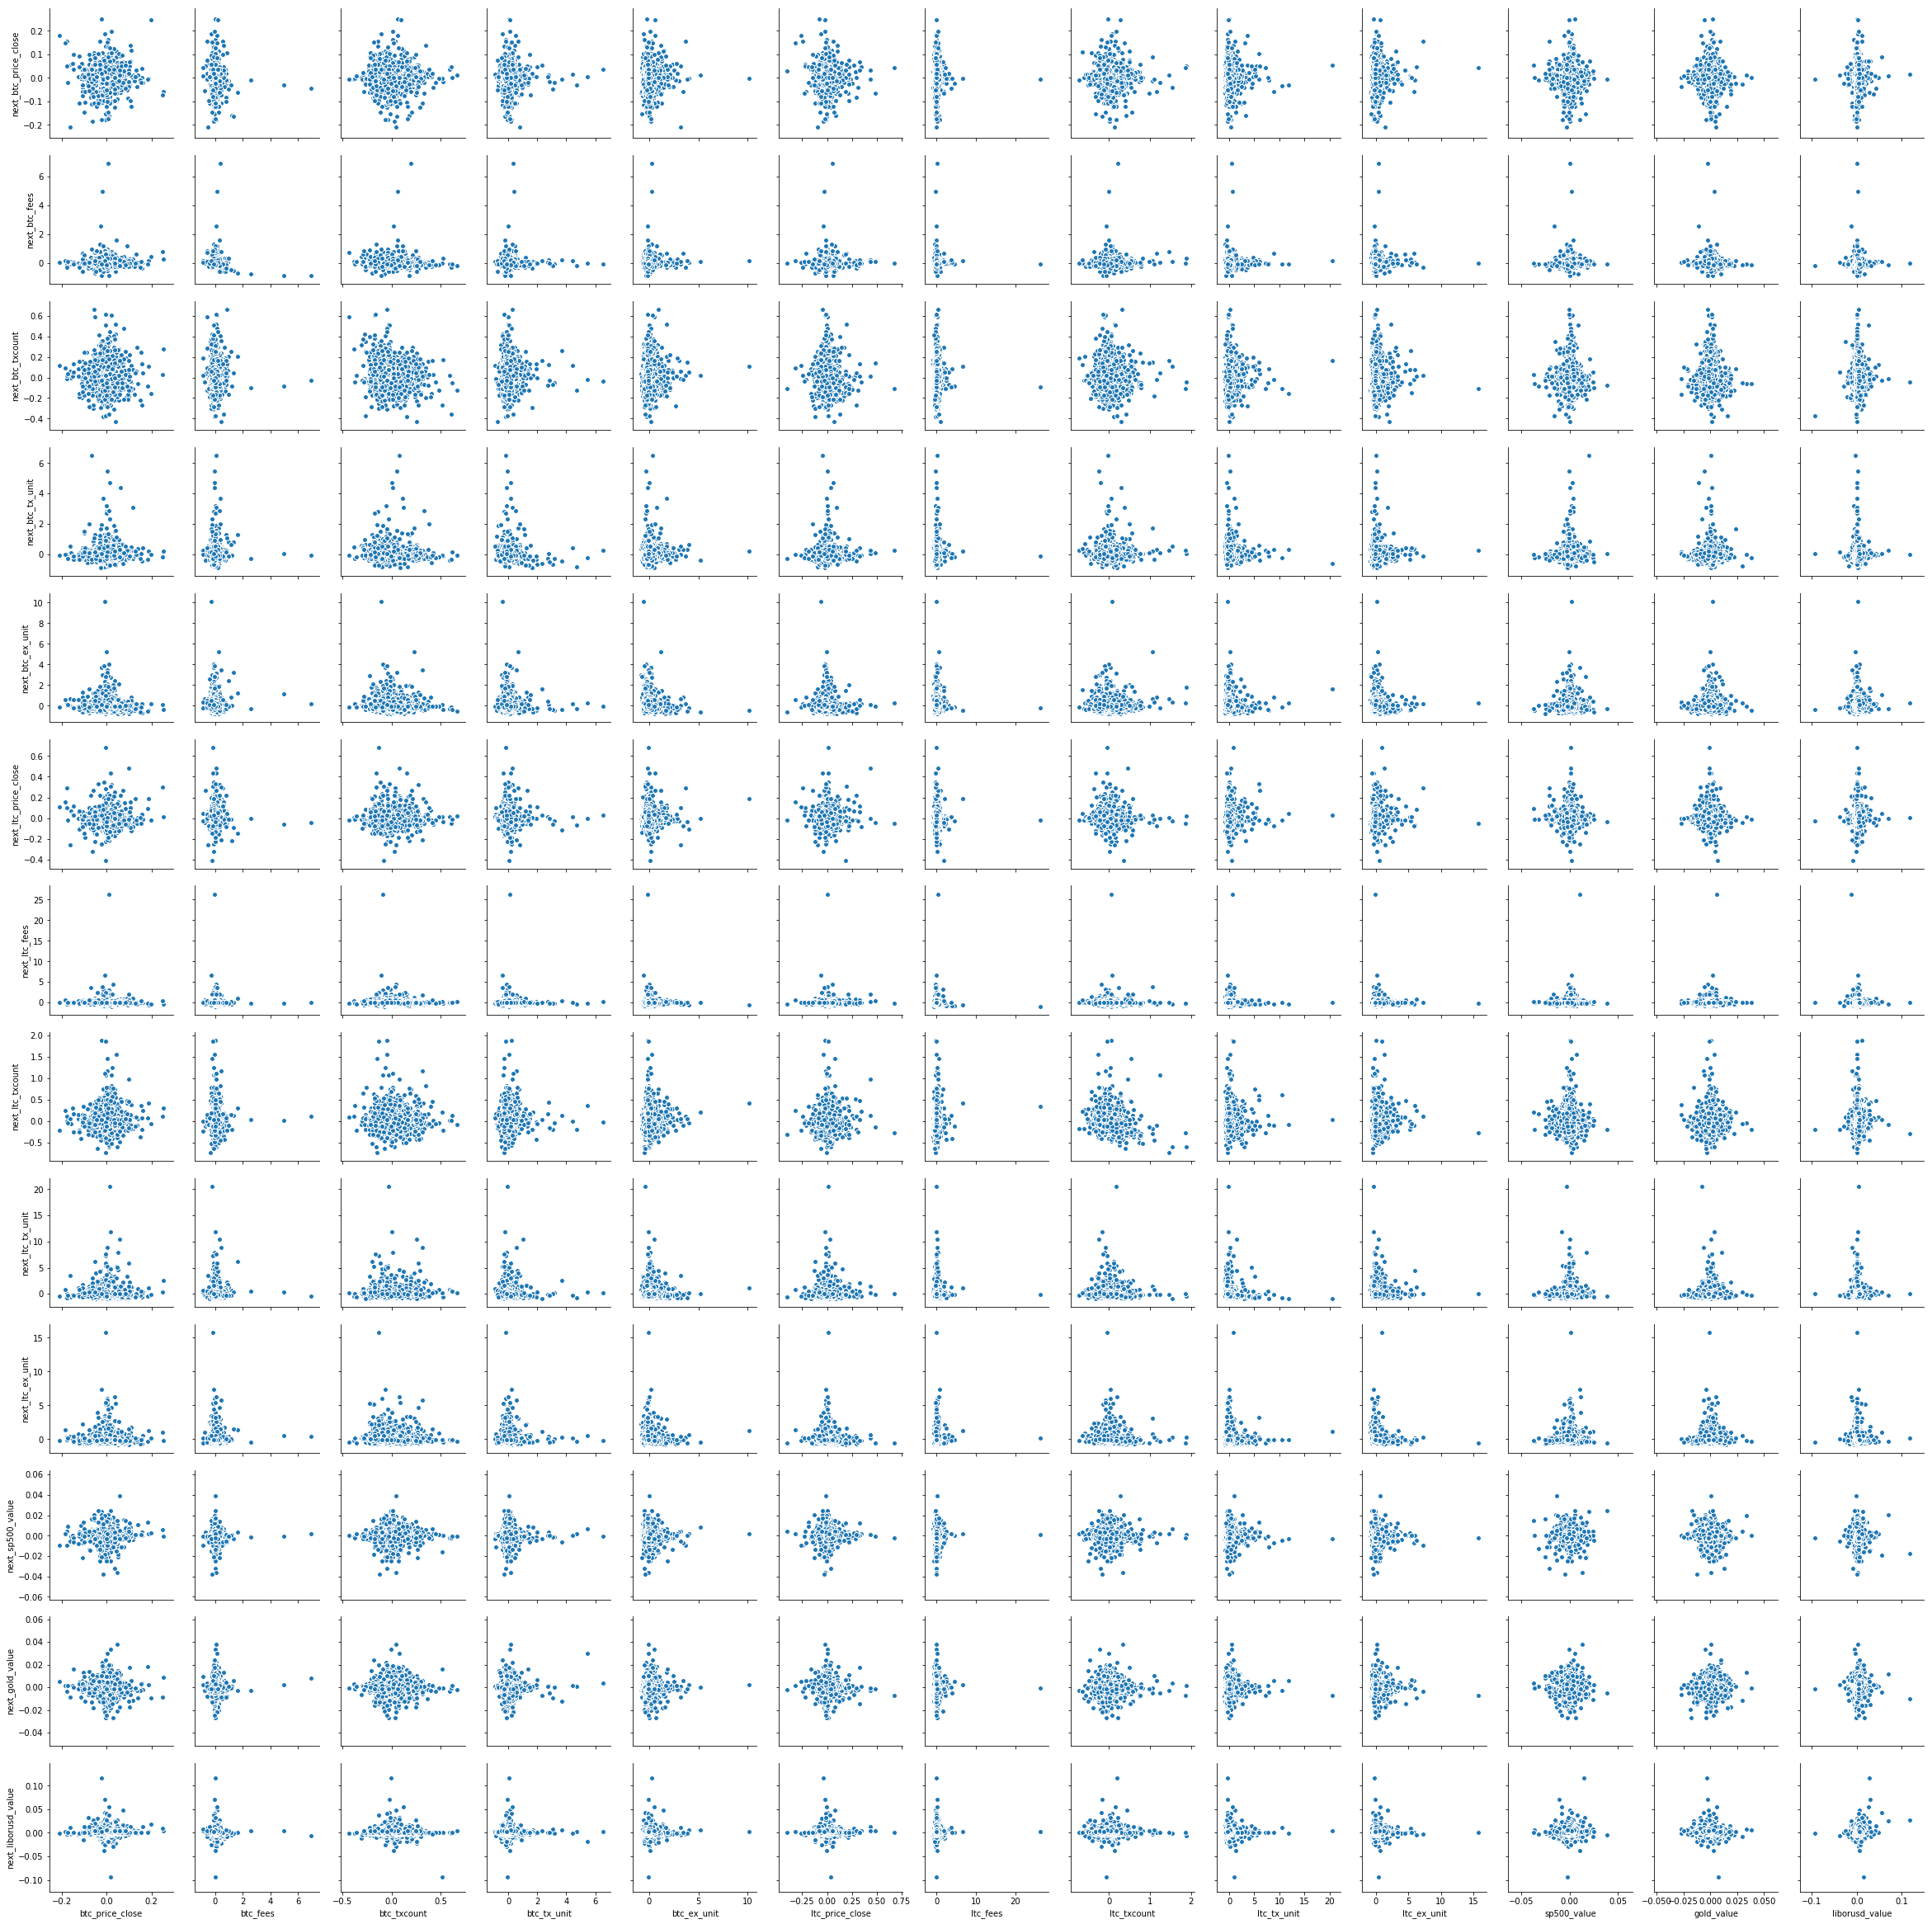

In [24]:
sns.pairplot(df_temp.dropna(),x_vars = df_returns.columns, y_vars = df_returns_next.columns)

btc_price_close 1547


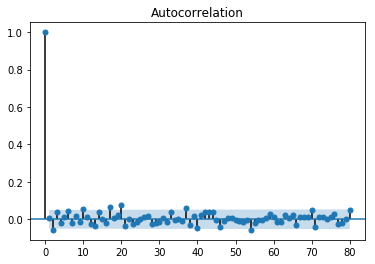

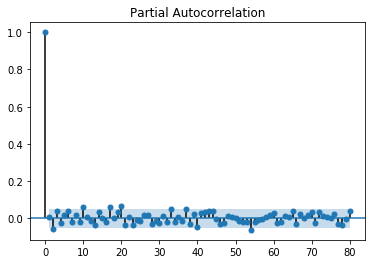


btc_fees 1547


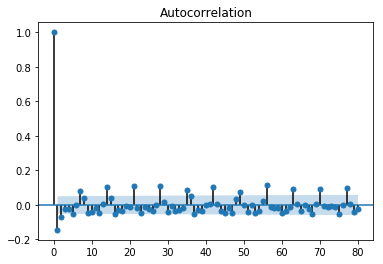

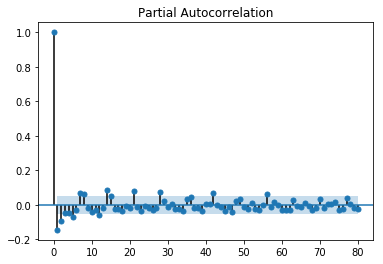


btc_txcount 1547


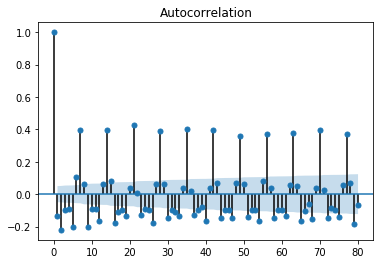

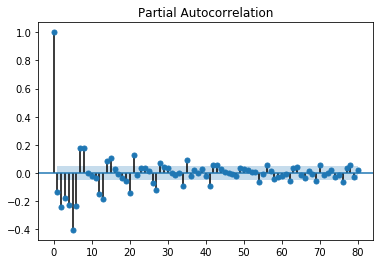


btc_tx_unit 1547


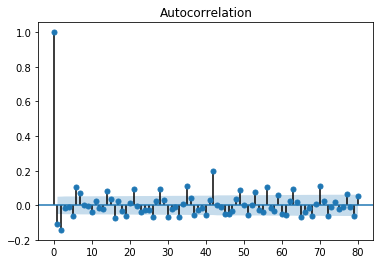

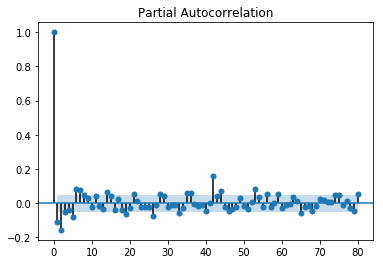


btc_ex_unit 1547


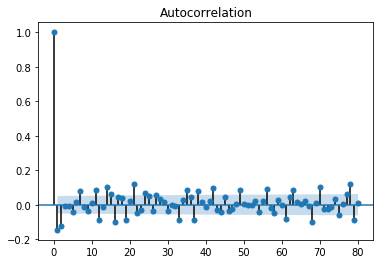

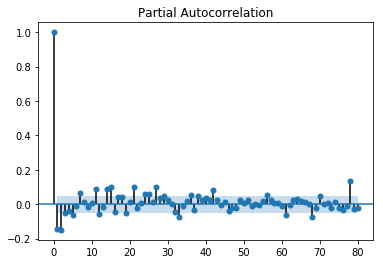


ltc_price_close 1547


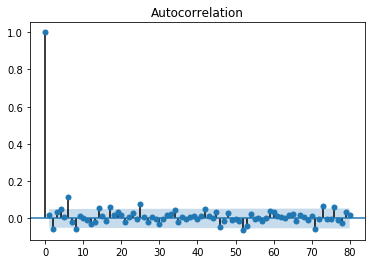

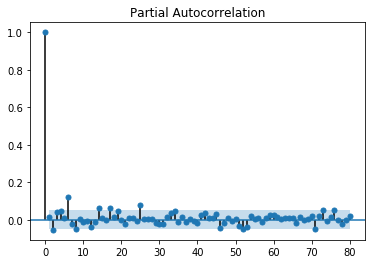


ltc_fees 1547


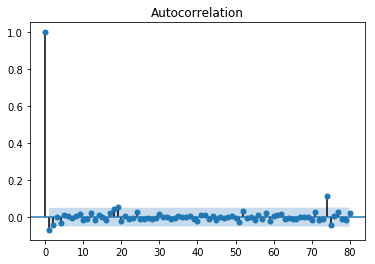

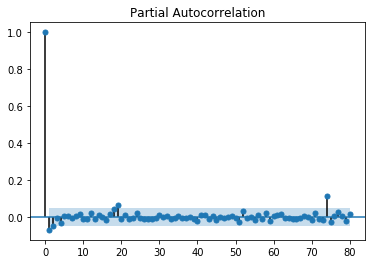


ltc_txcount 1547


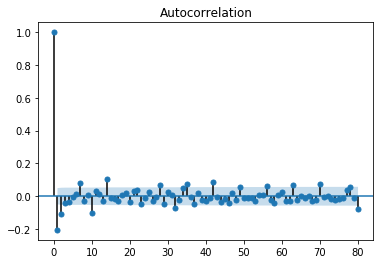

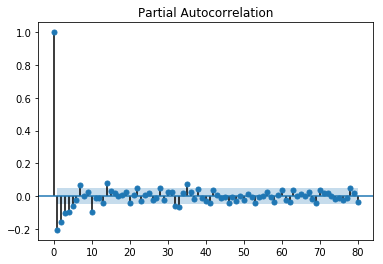


ltc_tx_unit 1547


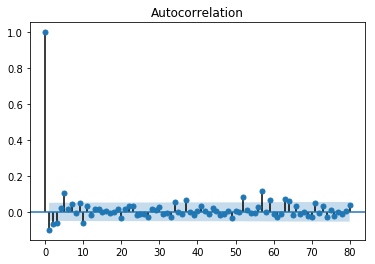

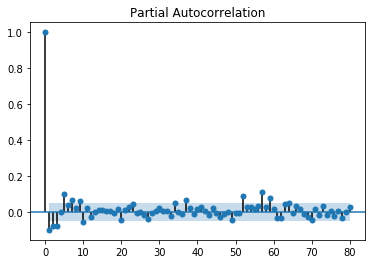


ltc_ex_unit 1547


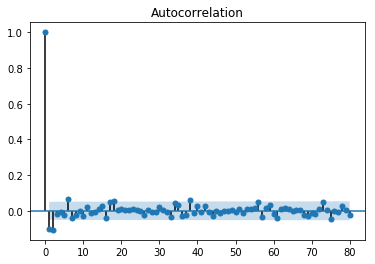

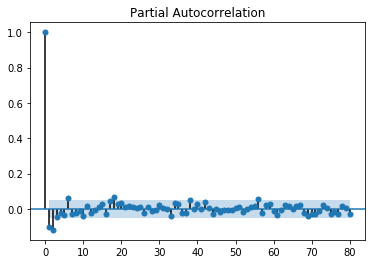


sp500_value 1547


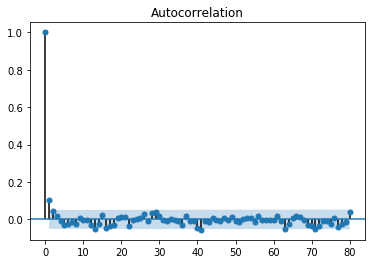

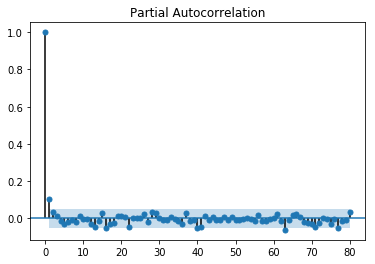


gold_value 1547


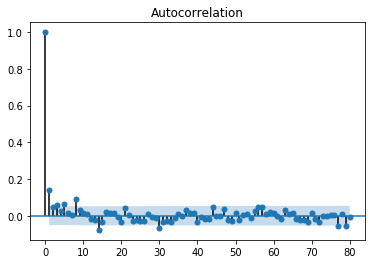

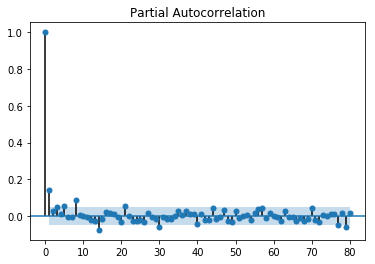


liborusd_value 1547


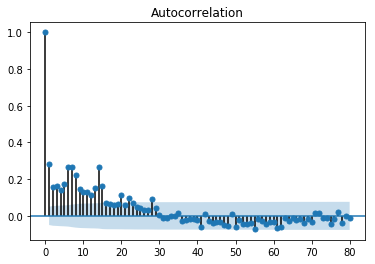

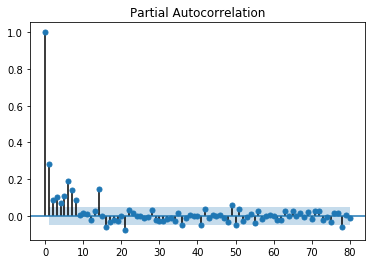

In [25]:
for f in df_returns.columns:
    print(f, len(df_returns.dropna()[f]))
    plot_acf(df_returns.dropna()[f], lags=80)
    plt.show() 

    plot_pacf(df_returns.dropna()[f], lags=80)
    plt.show()
    
    print("")



## BTC Regression

### Helper Functions

#### TS to ML format

In [11]:
def dataframe_ts_to_supervised(df, pred_vars, n_input=1, n_pred=1, dropnan=True, separate_xy=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        df: Sequence of observations as a list or NumPy array.
        pred_vars: columns for prediction (Y)
        n_in: Number of lag time steps as input (Xt, Xt-1, ..., Xt-n_in-1).
        n_out: Number of observations as output (yt+1, ..., yt+n_out).
        dropnan: Boolean whether or not to drop rows with NaN values.
        separate_xy: Boolean whether to return combined X+Y df or tuple X df, Y df
    Returns:
        Pandas DataFrame framed for supervised learning.
    """
    n_vars = df.shape[1]
    var_names = df.columns 
    n_pred_vars = len(pred_vars)
    cols, names = list(), list()
    
    # input sequence (t, ..., t-n)
    for i in range(0, n_input):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{}(t)'.format(var_names[j], i)) for j in range(n_vars)]
        else:
            names += [('{}(t-{})'.format(var_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t+1, ... t+n)
    for i in range(1, n_pred+1):
        cols.append(df[pred_vars].applymap(lambda x: 0 if x<=0 else 1).shift(-i))
        names += [('{}(t+{})'.format(pred_vars[j], i)) for j in range(n_pred_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    if separate_xy:
        return (agg.iloc[:,:-n_pred],agg.iloc[:,-n_pred:])
    else:
        return agg

#### Validation Loop

In [ ]:
def validation_regress(model, X_in, Y_in, rand_state=42, folds = 5):
    '''
    Runs the model on the given data
    Input: 
        required: model, X (input), Y (target)
        optional: rand_state, folds (passes these through to kfolds)
    Output: prints model stats, shows diagnostic charts, returns fitted model
    '''
    ts_split = TimeSeriesSplit(n_splits=folds)

    model_rmse, model_mad, model_r2, model_train_r2 = [],[],[],[]
    
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15,3)
    ax[0].set_title("Predict vs. Observed")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Observed")
    
    ax[1].set_title("Predict vs. Residuals")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residuals")
    
    ax[2].set_title("Norm Dist vs. Residuals (Q-Q)")
    ax[2].set_xlabel("Norm Quantiles")
    ax[2].set_ylabel("Residual Quantiles")

    colors = ["b","g","r","c","m","y","k","w"]
    
    i = 0
    min_point = np.inf
    max_point = np.inf*(-1)
    
    X_arg,Y_arg = np.array(X_in),np.array(Y_in)

    for train_ind, test_ind in ts_split.split(X_arg,Y_arg):
    
        X_train = X_arg[train_ind]
        X_test = X_arg[test_ind]
        Y_train = Y_arg[train_ind]
        Y_test = Y_arg[test_ind]

        model.fit(X_train,Y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        model_rmse.append(np.sqrt(np.mean((test_pred - Y_test)**2)))
        model_mad.append(np.mean(np.abs(test_pred - Y_test)))
        model_r2.append(model.score(X_test,Y_test))
        model_train_r2.append(model.score(X_train,Y_train))
        
        #Prediction vs actual
        min_point = min(min_point, max(np.min(Y_test),np.min(test_pred)))
        max_point = max(max_point, min(np.max(Y_test),np.max(test_pred)))
        ax[0].scatter(test_pred,Y_test, alpha=.1, c=colors[i%len(colors)])

        #Residuals
        ax[1].scatter(test_pred, Y_test-test_pred, alpha=.1, c=colors[i%len(colors)])
        #plt.show()
        
        #Q-Q plot
        (x_norm, y_resid), (slope,intercept,_) = stats.probplot(Y_test-test_pred, dist="norm")
        ax[2].scatter(x_norm,y_resid,alpha=.1,c=colors[i%len(colors)])
        ax[2].plot(x_norm, slope*x_norm+intercept)
        
        i+=1
            
    ax[0].plot([min_point,max_point],[min_point,max_point],c="k")
    plt.show()

    #R-square
    print("Test R2:     ", np.mean(model_r2),"std dev:",np.std(model_r2))
    print("Train R2:    ", np.mean(model_train_r2),"std dev:",np.std(model_train_r2))
    
    #RMSE
    print("RMSE:        ",np.mean(model_rmse),"std dev:",np.std(model_rmse))
    
    # Mean Absolute Deviation
    print("Mean Abs Dev:",np.mean(model_mad),"std dev:",np.std(model_mad))

    #values
    print("Test RMSE values:",[round(x,4) for x in model_rmse])
    #print("Mean Abs Dev values:",model_mad)
    print("Test R Square values:",[round(x,4) for x in model_r2])
    #print("Train R Square values:",model_train_r2)

    model.fit(X_arg, Y_arg)
    return model

In [69]:
def validation_classify(model,X,Y,k=5,rand_state=1):
    ''' Runs k-fold validation loop for input model, X, Y. Prints classification accuracy 
             and the following per-label metrics: precision, recall, f1, support.
        Inputs: 
                ylabel_strings -> the target labels
    '''
    ts_split = TimeSeriesSplit(n_splits=k)
    
    test_accs, test_scores = [], []
    train_accs, train_scores = [], []
    
    #X, Y = X_in.reset_index(drop=True),Y_in.reset_index(drop=True)
    
    i=1

    for train_ind, test_ind in ts_split.split(X,Y):
        print("Starting {} of {} folds".format(i,k))

        model.fit(X.iloc[train_ind],Y.iloc[train_ind])
        
        #Train metrics
        pred = model.predict(X.iloc[train_ind])
        acc = skm.accuracy_score(Y.iloc[train_ind],pred)
        train_accs.append(acc)
        score = skm.precision_recall_fscore_support(Y.iloc[train_ind],pred)
        train_scores.append(score)
        
        #Test metrics
        pred = model.predict(X.iloc[test_ind])
        acc = skm.accuracy_score(Y.iloc[test_ind],pred)
        test_accs.append(acc)
        score = skm.precision_recall_fscore_support(Y.iloc[test_ind],pred)
        test_scores.append(score)
        #print(acc)
        #print(skm.classification_report(Y[test_ind],pred))

        i+=1
    
    print("\nConfusion Matrix")
    print(skm.confusion_matrix(Y.iloc[test_ind],pred))
    
    print("\nAvg. Train Metrics")
    print ("Accuracy: {:.5f}".format(np.average(train_accs)))
    print_scores(np.average(train_scores,axis=0),np.unique(Y))
    
    print("\nAvg. Validation Metrics")
    print ("Accuracy: {:.5f}".format(np.average(test_accs)))
    print_scores(np.average(test_scores,axis=0),np.unique(Y))
    
def print_scores(scores_array, ylabel_strings):
    ''' Prints a table with headings for output of sklearn.metrics.precision_recall_fscore_support
        Inputs: scores_array -> np.array of scores from skm.
                ylabel_strings -> the target labels
    '''
    #Each row is a score in the output, transpose to get features across rows
    array = np.transpose(scores_array) 
    macro_avg = np.average(array,axis=0)
    labels = sorted(ylabel_strings)
    
    max_len = str(np.max([len(str(s)) for s in ylabel_strings]))
        
    print(("\n{:>"+max_len+"} {:>10s} {:>10s} {:>10s} {:>10s}").format("","Precision","Recall","F1","Support"))
    
    for i in range(len(labels)):
        print(("{:>"+max_len+"} {:>10.5f} {:>10.5f} {:>10.5f} {:>10.0f}")
              .format(labels[i],array[i][0],array[i][1],array[i][2],array[i][3]))
    
    print(("{:>"+max_len+"} {:>10.5f} {:>10.5f} {:>10.5f} {:>10.0f}")
          .format("Avg/Tot",macro_avg[0],macro_avg[1],macro_avg[2],macro_avg[3]))

#### Baseline predictors

In [20]:
# class PersistenceBaseline():
#     '''
#     Model which always predicts the previous value (t+1 = t)
#     **Assumes the predicted variable is the first X column**
#     '''
#     def __init__(self):
#         pass
#     def fit(self,X,Y):
#         pass
#     def predict(self,X):
#         return np.array(map(lambda x:0 if x<= 0 else 1,X[:,0]))
#     def score(self, X, Y):
#         return r2_score(Y,self.predict(X))

# class MeanBaseline():
#     '''
#     Model which always predicts the mean training set value
#     **Assumes the predicted variable is the first X column**
#     '''
#     def __init__(self):
#         pass
#     def fit(self,X,Y):
#         self.mean = round(np.sum(map(lambda x:0 if x<= 0 else 1,X[:,0]))/len(X),0)
#     def predict(self,X):
#         return [self.mean]*(X.shape[0])
#     def score(self, X, Y):
#         return r2_score(Y,self.predict(X))


### Predictions

In [22]:
# X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"])
# Y = Y.iloc[:,0]

# model = do_data_science(PersistenceBaseline(),X,Y)

# model = do_data_science(MeanBaseline(),X,Y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f502a061da0>]],
      dtype=object)

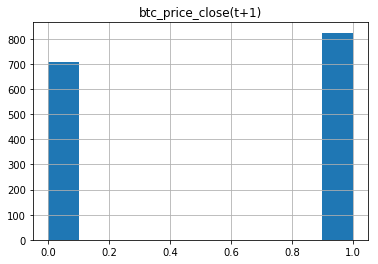

In [27]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=5)
Y.hist()

In [70]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=5)
Y = Y.iloc[:,0]

validation_classify(LogisticRegression(),X,Y)


Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Confusion Matrix
[[ 36  75]
 [ 40 104]]

Avg. Train Metrics
Accuracy: 0.58903

     Precision     Recall         F1    Support
0.0    0.59042    0.62961    0.59824        385
1.0    0.58418    0.52159    0.53804        382
Avg/Tot    0.58730    0.57560    0.56814        384

Avg. Validation Metrics
Accuracy: 0.49725

     Precision     Recall         F1    Support
0.0    0.43795    0.55650    0.48096        112
1.0    0.54705    0.42905    0.46803        143
Avg/Tot    0.49250    0.49277    0.47450        128


In [71]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = validation_classify(RandomForestClassifier(n_estimators=500, min_samples_leaf=4,n_jobs=-1),X,Y)

#list(zip(X.columns, model.feature_importances_))

Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Confusion Matrix
[[ 22  89]
 [ 27 116]]

Avg. Train Metrics
Accuracy: 1.00000

     Precision     Recall         F1    Support
0.0    1.00000    1.00000    1.00000        383
1.0    1.00000    1.00000    1.00000        382
Avg/Tot    1.00000    1.00000    1.00000        382

Avg. Validation Metrics
Accuracy: 0.52756

     Precision     Recall         F1    Support
0.0    0.45650    0.59983    0.49628        111
1.0    0.58824    0.43991    0.46617        143
Avg/Tot    0.52237    0.51987    0.48122        127


In [72]:
X, Y = dataframe_ts_to_supervised(df_returns["2016":],["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = validation_classify(RandomForestClassifier(n_estimators=500, min_samples_leaf=4,n_jobs=-1),X,Y)

#list(zip(X.columns, model.feature_importances_))

Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Confusion Matrix
[[ 4 55]
 [ 2 72]]

Avg. Train Metrics
Accuracy: 1.00000

     Precision     Recall         F1    Support
0.0    1.00000    1.00000    1.00000        165
1.0    1.00000    1.00000    1.00000        239
Avg/Tot    1.00000    1.00000    1.00000        202

Avg. Validation Metrics
Accuracy: 0.57744

     Precision     Recall         F1    Support
0.0    0.36071    0.09299    0.13276         54
1.0    0.59599    0.91403    0.71786         79
Avg/Tot    0.47835    0.50351    0.42531         66


In [73]:
X, Y = dataframe_ts_to_supervised(df_returns[:"2017"],["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = validation_classify(RandomForestClassifier(n_estimators=500, min_samples_leaf=4,n_jobs=-1),X,Y)

#list(zip(X.columns, model.feature_importances_))

Starting 1 of 5 folds
Starting 2 of 5 folds
Starting 3 of 5 folds
Starting 4 of 5 folds
Starting 5 of 5 folds

Confusion Matrix
[[ 18  78]
 [ 33 111]]

Avg. Train Metrics
Accuracy: 1.00000

     Precision     Recall         F1    Support
0.0    1.00000    1.00000    1.00000        365
1.0    1.00000    1.00000    1.00000        360
Avg/Tot    1.00000    1.00000    1.00000        362

Avg. Validation Metrics
Accuracy: 0.50917

     Precision     Recall         F1    Support
0.0    0.42792    0.59609    0.48179        105
1.0    0.55720    0.39768    0.42649        135
Avg/Tot    0.49256    0.49688    0.45414        120


AttributeError: 'NoneType' object has no attribute 'feature_importances_'

In [76]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=40)
Y = Y.iloc[:,0]

model = validation_classify(xgb.XGBClassifier(n_estimators = 200, n_jobs=-1),X,Y,k=10)

#sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)

Starting 1 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 2 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 3 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 4 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 5 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 6 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 7 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 8 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 9 of 10 folds


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Starting 10 of 10 folds

Confusion Matrix
[[22 39]
 [24 51]]

Avg. Train Metrics
Accuracy: 0.99963

     Precision     Recall         F1    Support
0.0    1.00000    0.99920    0.99960        367
1.0    0.99933    1.00000    0.99966        382
Avg/Tot    0.99966    0.99960    0.99963        374

Avg. Validation Metrics
Accuracy: 0.51618

     Precision     Recall         F1    Support
0.0    0.46955    0.44124    0.44676         61
1.0    0.53937    0.55955    0.54518         75
Avg/Tot    0.50446    0.50040    0.49597         68


/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/perry/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


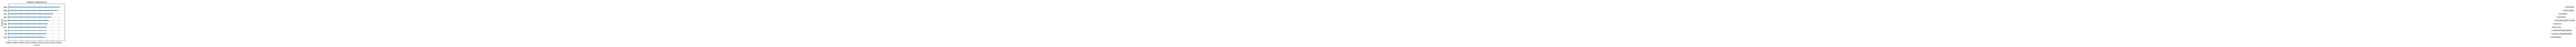

In [51]:
#xgb.plot_importance(model, importance_type="weight")

xgb.plot_importance(model, importance_type="gain", max_num_features=10)

